In [3]:
%load_ext cython

In [4]:
%%cython
import numpy as np
from mpire import WorkerPool

pool = WorkerPool(n_jobs=4)

cdef float epsilon, delta, LB, UB, mu, sig
cdef int n_max
cdef int n, t
cdef list X_t

epsilon = 0.01
delta = 0.05
n_max = 213

def eB_n(n, sig, delta = 0.05, epsilon = 0.01):
    return sig * np.sqrt(2*np.log(3*n_max/delta)/n**2) + 3*np.log(3*n_max/delta)/n**2

def ILEBR2(symulation, p1, p2, delta = 0.05, epsilon = 0.01, n_max = n_max):
    LB = 0
    UB = 1
    t = 1
    sumx=0
    sumx2=0
    for n in range(1, n_max+1):
        for i in range(2*n - 1):
            Xt = np.random.choice([1, 0],p=[0.5, 0.5])
            # Xt= symulation(p1, p2)
            t+=1
            sumx += Xt
            sumx2 += Xt**2
            mu = sumx/(t)
            sig = np.sqrt(sumx2/t - mu**2)
        e_n = eB_n(n, sig)
        LB = max(LB, mu - e_n)
        UB = min(UB, mu + e_n)
        if UB - LB < 2*epsilon:
            break
    return mu

In [43]:
%%cython
import numpy as np
from mpire import WorkerPool
import scipy as sci

pool = WorkerPool(n_jobs=4)

cdef float epsilon, delta, LB, UB, mu, sig
cdef int n, t, n_max
cdef list X_t

epsilon = 0.01
delta = 0.05
n_max = 213

def eB_n(n, sig, delta = 0.05, epsilon = 0.01):
    return sig * np.sqrt(2*np.log(3*n_max/delta)/n**2) + 3*np.log(3*n_max/delta)/n**2
    
def ILEBR2_test(p, delta = 0.05, epsilon = 0.01, n_max = n_max):
    np.random.seed()
    LB = 0
    UB = 1
    t = 1
    sumx=0
    sumx2=0
    for n in range(1, n_max+1):
        for i in range(2*n - 1):
            Xt = np.random.choice([1, 0],p=[p, 1-p])
            # Xt= symulation(p1, p2)
            t+=1
            sumx += Xt
            sumx2 += Xt**2
            mu = sumx/(t)
            sig = np.sqrt(sumx2/t - mu**2)
        e_n = eB_n(n, sig)
        LB = max(LB, mu - e_n)
        UB = min(UB, mu + e_n)
        if UB - LB < 2*epsilon:
            break
    return mu, n**2

ps1 = np.arange(0.495, 0.5+0.0005, 0.0005)
ps1 = np.linspace(0.495, 0.5+0.0005,3)

# x1_ILEBR2 = np.array([pool.map(ILEBR2_test, [p]*100) for p in ps1])

ps2 = np.arange(0, 0.5+0.05, 0.05)
x2_ILEBR2 = np.array([pool.map(ILEBR2_test, [p]*100) for p in ps2])

In [44]:
symulation_p_ILEBR2 = x1_ILEBR2[:, :, 0]
symulation_n_ILEBR2 = x2_ILEBR2[:, :, 1]

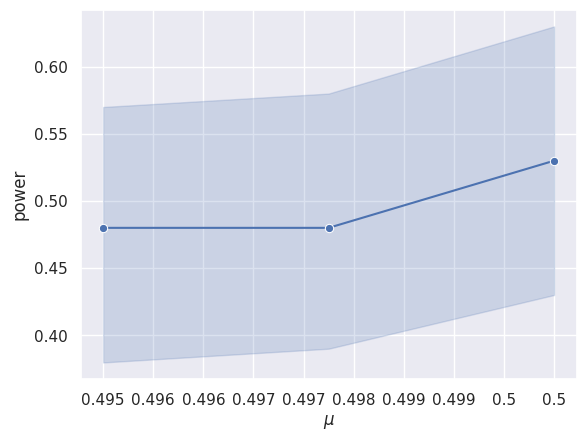

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme(style="darkgrid")

ILEBR2_df = pd.DataFrame((symulation_p_ILEBR2>0.5).T.astype(int))
ILEBR2_df.columns = ps1
ILEBR2_df = pd.melt(ILEBR2_df)
sns.lineplot(data=ILEBR2_df, x="variable", y="value", marker="o")
xs = np.linspace(min(ps1), max(ps1),10)
plt.xticks(xs,np.round(xs, 3))
plt.ylabel("power")
plt.xlabel("$\mu$")
plt.show()

      0      1      2      3      4      5      6      7      8      9      10
0   38.0  117.0  146.0  147.0  183.0  196.0  210.0  213.0  213.0  213.0  213.0
1   38.0  118.0  145.0  170.0  183.0  192.0  206.0  212.0  213.0  213.0  213.0
2   38.0  120.0  146.0  166.0  174.0  199.0  203.0  208.0  213.0  213.0  213.0
3   38.0  118.0  147.0  162.0  183.0  187.0  208.0  208.0  213.0  213.0  213.0
4   38.0  120.0  149.0  168.0  187.0  198.0  211.0  209.0  213.0  211.0  213.0
..   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
95  38.0  115.0  147.0  171.0  178.0  199.0  209.0  211.0  213.0  213.0  213.0
96  38.0  113.0  149.0  168.0  186.0  200.0  208.0  205.0  213.0  203.0  213.0
97  38.0  115.0  149.0  167.0  183.0  191.0  205.0  213.0  213.0  213.0  213.0
98  38.0  119.0  142.0  169.0  187.0  200.0  182.0  213.0  209.0  213.0  213.0
99  38.0  120.0  147.0  170.0  189.0  191.0  210.0  212.0  213.0  213.0  213.0

[100 rows x 11 columns]


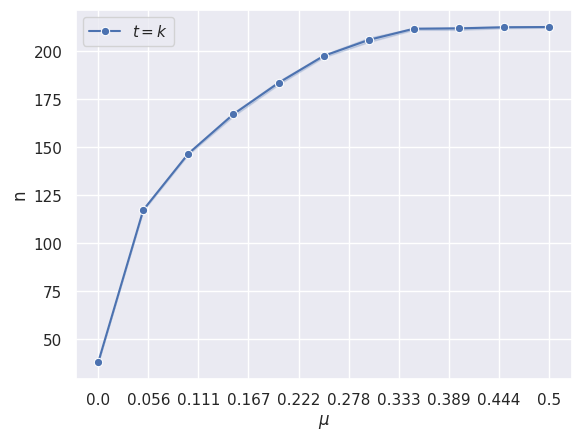

In [47]:
sns.set(style="darkgrid")

ILEBR2_df_n_df = pd.DataFrame(symulation_n_ILEBR2.T)
ILEBR2_df_n_df.columns = ps2
# LEBR_n_df = pd.melt(LEBR_df)
ILEBR2_df_n_df = pd.melt(ILEBR2_df_n_df)

# sns.boxplot(data=LEBR_n_df, x="variable", y="value", color= "black", medianprops={"color": "red"})
sns.lineplot(data=ILEBR2_df_n_df, x="variable", y="value", marker= 'o')
xs = np.linspace(min(ps2),max(ps2),10)
plt.xticks(xs, np.round(xs, 3))
# xs = np.linspace(min(ps2),max(ps2),len(ps))
# plt.xticks(range(len(ps)), np.round(xs, 3))

plt.ylabel("n")
plt.xlabel("$\mu$")
plt.legend(["$t=k$"])
# plt.xticks(range(len(ps)),(np.linspace(min(ps2),max(ps2),len(ps)))

# df1 = LEBR_df.assign(type = 1)
# df2 = (LEBR_df+0.01).assign(type = 2)
# df = pd.concat([df1,df2])
# df = pd.melt(LEBR_df, id_vars="type")

# sns.boxplot(data = df, x="variable", y="value",hue="type")
plt.show()

In [12]:
%%cython
import numpy as np
from mpire import WorkerPool


cdef float epsilon, delta, LB, UB, mu, sig
cdef short n_max
cdef int n, t
cdef list X_t

epsilon = 0.01
delta = 0.05
n_max = 208
t0 = 6-1
def cB_n(n, sig, delta = 0.05, epsilon = 0.01):
    return sig * np.sqrt(2*np.log(3*n_max/delta)/(n+t0)**2) + 3*np.log(3*n_max/delta)/(n+t0)**2
# def cB_n(n, sig, delta = 0.05, epsilon = 0.01):
    # return sig * np.sqrt(2*np.log(3*n**2*np.pi**2/6/delta)/n**2) + 3*np.log(3*n**2*np.pi**2/6/delta)/n**2

def IEBLR2(symulation, p1, p2, delta = 0.05, epsilon = 0.01, n_max = 191, n_jobs = 4):
    LB = 0
    UB = 1
    t = 1
    X_t = []
    # with WorkerPool(n_jobs=n_jobs) as pool:
    #  pool = WorkerPool(n_jobs=n_jobs)
    for n in range(1, n_max):
        X_t.extend(np.random.random(size=2*n - 1)/2)
            # X_t.extend(pool.map(symulation, [[p1, p2]]*t))
        mu = np.mean(X_t)  
        sig = np.std(X_t)
        cn = cB_n(n, sig)
        LB = max(LB, mu - cn)
        UB = min(UB, mu + cn)
        if UB - LB < 2*epsilon:
            break
        elif UB < 0.5:
            break
        elif LB > 0.5:
            break
    if LB > 0.5:
        return 1
    elif UB < 0.5:
        return 2
    elif mu > 0.5:
        return 1
    else:
        return 2

In [15]:
x = np.array([IEBLR(1,2,3) for i in range(10)])
print(np.mean(x))

0.24998819459352878


In [6]:
IEBLR(1,2,3)

Process ForkWorker-17:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process ForkWorker-18:
  File "/home/olek/.local/lib/python3.10/site-packages/mpire/worker.py", line 164, in run
    func = self._get_func(additional_args)
  File "/home/olek/.local/lib/python3.10/site-packages/mpire/worker.py", line 251, in _get_func
    partial(self.map_params.func, *additional_args))
Traceback (most recent call last):
TypeError: the first argument must be callable
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process ForkWorker-19:
  File "/home/olek/.local/lib/python3.10/site-packages/mpire/worker.py", line 164, in run
    func = self._get_func(additional_args)
  File "/home/olek/.local/lib/python3.10/site-packages/mpire/worker.py", line 251, in _get_func
    partial(self.map_params.func, *additional_args))
Traceback (most recent call last):
TypeError: the first ar

KeyboardInterrupt: 